In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/courses/21_fall/ML/lab3")

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
import sys
import h5py
import numpy as np

In [ ]:
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0, 2, 3, 1))

    return x_data, y_data


In [ ]:
clean_data_filename = './valid.h5'
clean_testdata_filename = './test.h5'
poisoned_data_filename = './bd_test.h5'
model_filename = './bd_net.h5'

cl_x_valid, cl_y_valid = data_loader(clean_data_filename)
cl_x_test, cl_y_test = data_loader(clean_testdata_filename)
bd_x_test, bd_y_test = data_loader(poisoned_data_filename)
net = keras.models.load_model(model_filename)

In [ ]:
import pandas as pd

In [ ]:
pool3 = net.get_layer('pool_3').output
pool3_net = keras.models.Model(net.input, pool3)
activation_all = pool3_net.predict(cl_x_valid)
print(activation_all.shape)

(11547, 5, 4, 60)


In [ ]:
activation = np.mean(activation_all, axis=(0,1,2))
print(activation.shape)

(60,)


In [ ]:
cl_label_or = np.argmax(net.predict(cl_x_valid), axis=1)
or_accuracy = np.mean(np.equal(cl_label_or, cl_y_valid))*100
print('Original Classification accuracy:', or_accuracy)

Original Classification accuracy: 98.64899974019225


In [ ]:
conv3_num = 60

seq_sort = np.argsort(activation)

X_list = [0.02,0.04,0.10,0.30]
sa=1
acc_list = []
asr_list = []

conv3 = net.get_layer("conv_3")
weight,bias = conv3.get_weights()

for i in range(60):
    channel = seq_sort[i]

    #conv3 = net.get_layer("conv_3")
    #weight,bias = conv3.get_weights()
    weight[:, :, :, channel] = 0. 
    bias[channel] = 0.
    conv3.set_weights((weight,bias))

    cl_label_v = np.argmax(net.predict(cl_x_valid), axis=1)
    valid_accuracy = np.mean(np.equal(cl_label_v, cl_y_valid))*100
    print('Clean Valid Classification accuracy:', valid_accuracy)

    if valid_accuracy < or_accuracy*(1-X_list[0]) and sa == 1:
      net.save("2% model.h5")
      sa = 2
    elif valid_accuracy < or_accuracy*(1-X_list[1]) and sa == 2:
      net.save("4% model.h5")
      sa = 3
    elif valid_accuracy < or_accuracy*(1-X_list[2]) and sa == 3:
      net.save("10% model.h5")
      sa = 4
    elif valid_accuracy < or_accuracy*(1-X_list[3]) and sa == 4:
      net.save("30% model.h5")

    cl_label_p = np.argmax(net.predict(cl_x_test), axis=1)
    clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_test))*100
    print('Clean Classification accuracy:', clean_accuracy)

    acc_list.append(clean_accuracy)
    
    bd_label_p = np.argmax(net.predict(bd_x_test), axis=1)
    asr = np.mean(np.equal(bd_label_p, bd_y_test))*100
    print('Attack Success Rate:', asr)

    asr_list.append(asr)

Clean Valid Classification accuracy: 98.64899974019225
Clean Classification accuracy: 98.64899974019225
Attack Success Rate: 100.0
Clean Valid Classification accuracy: 98.64899974019225
Clean Classification accuracy: 98.64899974019225
Attack Success Rate: 100.0
Clean Valid Classification accuracy: 98.64899974019225
Clean Classification accuracy: 98.64899974019225
Attack Success Rate: 100.0
Clean Valid Classification accuracy: 98.64899974019225
Clean Classification accuracy: 98.64899974019225
Attack Success Rate: 100.0
Clean Valid Classification accuracy: 98.64899974019225
Clean Classification accuracy: 98.64899974019225
Attack Success Rate: 100.0
Clean Valid Classification accuracy: 98.64899974019225
Clean Classification accuracy: 98.64899974019225
Attack Success Rate: 100.0
Clean Valid Classification accuracy: 98.64899974019225
Clean Classification accuracy: 98.64899974019225
Attack Success Rate: 100.0
Clean Valid Classification accuracy: 98.64899974019225
Clean Classification accurac

/home/hx759/.local/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Clean Classification accuracy: 95.75647354291158
Attack Success Rate: 100.0
Clean Valid Classification accuracy: 95.20221702606739
Clean Classification accuracy: 95.20221702606739
Attack Success Rate: 99.9913397419243
Clean Valid Classification accuracy: 94.7172425738287
Clean Classification accuracy: 94.7172425738287
Attack Success Rate: 99.9913397419243
Clean Valid Classification accuracy: 92.09318437689443
Clean Classification accuracy: 92.09318437689443
Attack Success Rate: 99.9913397419243
Clean Valid Classification accuracy: 91.49562656967177
Clean Classification accuracy: 91.49562656967177
Attack Success Rate: 99.9913397419243
Clean Valid Classification accuracy: 91.01931237550879
Clean Classification accuracy: 91.01931237550879
Attack Success Rate: 99.98267948384861
Clean Valid Classification accuracy: 89.17467740538669
Clean Classification accuracy: 89.17467740538669
Attack Success Rate: 80.73958603966398
Clean Valid Classification accuracy: 84.43751623798389
Clean Classificat

this is the figure of the accuracy on clean test data and the attack success rate (on backdoored test data) as a function of the fraction of channels pruned. we can overserve that the clean acc and attack success rate remains high for the first 80% fraction of channels pruned, and rapidly decrease for the rest 20% channels. so this prune defense is not working for this model. I think it is becuase this attack is pruning-aware attack.

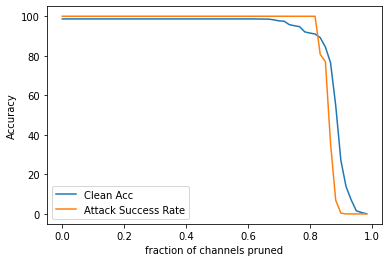

In [ ]:
import matplotlib.pyplot as plt

xx = np.array(range(60))
xx = xx/60

plt.plot(xx, acc_list, label = 'Clean Acc')
plt.plot(xx, asr_list, label = 'Attack Success Rate')

plt.xlabel("fraction of channels pruned")
plt.ylabel("Accuracy")

plt.legend()

Below, i evaluate the 4 repaired networks for 4 diffierent X%. i showed the clean acc and attack success rate of the 4 G nets.

In [ ]:
clean_data_filename = './valid.h5'
poisoned_data_filename = './bd_valid.h5'
model_filename = './bd_net.h5'
b_prime_model_filename = './2% model.h5'

cl_x_test, cl_y_test = data_loader(clean_data_filename)
bd_x_test, bd_y_test = data_loader(poisoned_data_filename)
net = keras.models.load_model(model_filename)
b_prime_net = keras.models.load_model(b_prime_model_filename)

cl_b = np.argmax(net.predict(cl_x_test), axis=1)
cl_b_p = np.argmax(b_prime_net.predict(cl_x_test), axis=1)
cl_g = []
for x1, x2 in zip(cl_b, cl_b_p):
    if x1 == x2:
        cl_g.append(x1)
    else:
        cl_g.append(1283)

cl_g_acc = np.mean(np.equal(cl_g, cl_y_test))*100
print('Clean Classification accuracy for 2% G net:', cl_g_acc)
    
    
    
bd_b = np.argmax(net.predict(bd_x_test), axis=1)
bd_b_p = np.argmax(b_prime_net.predict(bd_x_test), axis=1)
bd_g = []
for x1, x2 in zip(bd_b, bd_b_p):
    if x1 == x2:
        bd_g.append(x1)
    else:
        bd_g.append(1283)
        
asr = np.mean(np.equal(bd_g, bd_y_test))*100
print('Attack Success Rate for 2% G net:', asr)

Clean Classification accuracy for 2% G net: 95.61790941370053
Attack Success Rate for 2% G net: 100.0


In [ ]:
clean_data_filename = './valid.h5'
poisoned_data_filename = './bd_valid.h5'
model_filename = './bd_net.h5'
b_prime_model_filename = './4% model.h5'

cl_x_test, cl_y_test = data_loader(clean_data_filename)
bd_x_test, bd_y_test = data_loader(poisoned_data_filename)
net = keras.models.load_model(model_filename)
b_prime_net = keras.models.load_model(b_prime_model_filename)

cl_b = np.argmax(net.predict(cl_x_test), axis=1)
cl_b_p = np.argmax(b_prime_net.predict(cl_x_test), axis=1)
cl_g = []
for x1, x2 in zip(cl_b, cl_b_p):
    if x1 == x2:
        cl_g.append(x1)
    else:
        cl_g.append(1283)

cl_g_acc = np.mean(np.equal(cl_g, cl_y_test))*100
print('Clean Classification accuracy for 4% G net:', cl_g_acc)
    
    
    
bd_b = np.argmax(net.predict(bd_x_test), axis=1)
bd_b_p = np.argmax(b_prime_net.predict(bd_x_test), axis=1)
bd_g = []
for x1, x2 in zip(bd_b, bd_b_p):
    if x1 == x2:
        bd_g.append(x1)
    else:
        bd_g.append(1283)
        
asr = np.mean(np.equal(bd_g, bd_y_test))*100
print('Attack Success Rate for 4% G net:', asr)

Clean Classification accuracy for 4% G net: 91.85935740885078
Attack Success Rate for 4% G net: 99.9913397419243


In [ ]:
clean_data_filename = './valid.h5'
poisoned_data_filename = './bd_valid.h5'
model_filename = './bd_net.h5'
b_prime_model_filename = './10% model.h5'

cl_x_test, cl_y_test = data_loader(clean_data_filename)
bd_x_test, bd_y_test = data_loader(poisoned_data_filename)
net = keras.models.load_model(model_filename)
b_prime_net = keras.models.load_model(b_prime_model_filename)

cl_b = np.argmax(net.predict(cl_x_test), axis=1)
cl_b_p = np.argmax(b_prime_net.predict(cl_x_test), axis=1)
cl_g = []
for x1, x2 in zip(cl_b, cl_b_p):
    if x1 == x2:
        cl_g.append(x1)
    else:
        cl_g.append(1283)

cl_g_acc = np.mean(np.equal(cl_g, cl_y_test))*100
print('Clean Classification accuracy for 10% G net:', cl_g_acc)
    
    
    
bd_b = np.argmax(net.predict(bd_x_test), axis=1)
bd_b_p = np.argmax(b_prime_net.predict(bd_x_test), axis=1)
bd_g = []
for x1, x2 in zip(bd_b, bd_b_p):
    if x1 == x2:
        bd_g.append(x1)
    else:
        bd_g.append(1283)
        
asr = np.mean(np.equal(bd_g, bd_y_test))*100
print('Attack Success Rate for 10% G net:', asr)

Clean Classification accuracy for 10% G net: 84.24699056031871
Attack Success Rate for 10% G net: 77.015675067117


In [ ]:
clean_data_filename = './valid.h5'
poisoned_data_filename = './bd_valid.h5'
model_filename = './bd_net.h5'
b_prime_model_filename = './30% model.h5'

cl_x_test, cl_y_test = data_loader(clean_data_filename)
bd_x_test, bd_y_test = data_loader(poisoned_data_filename)
net = keras.models.load_model(model_filename)
b_prime_net = keras.models.load_model(b_prime_model_filename)

cl_b = np.argmax(net.predict(cl_x_test), axis=1)
cl_b_p = np.argmax(b_prime_net.predict(cl_x_test), axis=1)
cl_g = []
for x1, x2 in zip(cl_b, cl_b_p):
    if x1 == x2:
        cl_g.append(x1)
    else:
        cl_g.append(1283)

cl_g_acc = np.mean(np.equal(cl_g, cl_y_test))*100
print('Clean Classification accuracy for 30% G net:', cl_g_acc)
    
    
    
bd_b = np.argmax(net.predict(bd_x_test), axis=1)
bd_b_p = np.argmax(b_prime_net.predict(bd_x_test), axis=1)
bd_g = []
for x1, x2 in zip(bd_b, bd_b_p):
    if x1 == x2:
        bd_g.append(x1)
    else:
        bd_g.append(1283)
        
asr = np.mean(np.equal(bd_g, bd_y_test))*100
print('Attack Success Rate for 30% G net:', asr)

Clean Classification accuracy for 30% G net: 0.0779423226812159
Attack Success Rate for 30% G net: 0.0
